# Fooled colored MNIST (Try to put more focus on colors instead of the shape of the digits)
The idea is to create a model, which should be able to asses, if the digit in the image is a low or a high number. The image dataset of colored digits is divided into three parts namely the train, validation and test datasets. In the train and validatin datasets, the low numbers are colored in red and the high numbers are colored in green. In the test dataset, the colors are random. If the model is able to recognize the value of the digits from it's shape, the performance should be nearly equal as the performance on the train and validation datasets. The hypothesis is, that the model will learn to separate low from high digits based on their color and therefore will fail on the test dataset.

## Setup environment

In [ ]:
class align_emnist_like_mnist:
    """
    Align EMNIST images like MNIST images. For some dubious reason, the EMNIST images
    are flipped and rotated. (See its documentation)
    """
    def __init__(self):
        self.angle = 90

    def __call__(self, x):
        x = transforms.functional.hflip(x)
        return transforms.functional.rotate(img=x, angle=self.angle)
    
align_emnist_like_mnist()

In [ ]:
# EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
# EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.
# EMNIST Balanced:  131,600 characters. 47 balanced classes.
# EMNIST Letters: 145,600 characters. 26 balanced classes.
# EMNIST Digits: 280,000 characters. 10 balanced classes.
# EMNIST MNIST: 70,000 characters. 10 balanced classes.
asdf1 = datasets.mnist.EMNIST('./data', train=True, download=True, split="mnist", transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                  align_emnist_like_mnist()]))

In [ ]:
asdf1

In [ ]:
asdf2 = datasets.mnist.MNIST('./data', train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))

In [ ]:
asdf2

In [ ]:
asdf1[0][0][0].shape

In [ ]:
asdf2[0][0][0].shape

In [ ]:
for i in range(5):
    plt.imshow(np.transpose(asdf1[i][0].cpu().numpy(), (1,2,0)))
    plt.title(f"{i}")
    plt.show()


In [ ]:
for i in range(5):
    plt.imshow(np.transpose(asdf2[i][0].cpu().numpy(), (1,2,0)))
    plt.title(f"{i}")
    plt.show()


In [1]:
import torch

torch.cuda.empty_cache()

In [2]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision import __version__ as torchvision_version

%load_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

Torch version: 1.13.0a0+d0d6b1f


In [3]:
# include plots in notebook
%matplotlib inline

In [4]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision_version)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Tue Jan 10 21:54:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   37C    P0    69W / 350W |  32414MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

## Prepare dataset

In [5]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

# dataset parameters
DATASET_BATCH_SIZE = 128
DATASET_SHUFFLE = False

In [6]:
import clip

model, preprocess = clip.load("RN50")

In [7]:
def digit_distribution(datasource):
    """
    Displays a bar plot showing the number of 5s and 8s in the dataset.
    """
    nr_of_5s = 0
    
    for i in range(len(datasource)):
        nr_of_5s += (datasource[i][1].item() == 5)
    
    plt.bar((5,8), (nr_of_5s, len(datasource) - nr_of_5s))
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.title("Sample distribution")
    plt.show()

Preparing Colored MNIST
Scanning train image 0/60000
Scanning train image 5000/60000
Scanning train image 10000/60000
Scanning train image 15000/60000
Scanning train image 20000/60000
Scanning train image 25000/60000
Scanning train image 30000/60000
Scanning train image 35000/60000
Scanning train image 40000/60000
Scanning train image 45000/60000
Scanning validation image 50000/60000
Scanning validation image 55000/60000
Scanning test image 0/10000
Scanning test image 5000/10000
Scanning test_fool image 0/10000
Scanning test_fool image 5000/10000
Number of samples:  10000


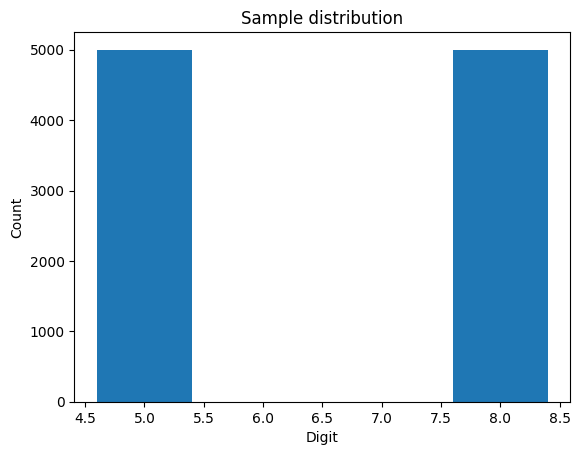

NameError: name 'plot_digits' is not defined

In [13]:
# create and select training dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='train',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='train',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
train_set = DatasetMNIST(root='./data',
                            env='train',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

print("Number of samples: ", len(train_set))
digit_distribution(train_set)
plot_digits(train_set, preprocess)

In [ ]:
# create and select validation dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='val',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='val',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
val_set = DatasetMNIST(root='./data',
                            env='val',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

print("Number of samples: ", len(val_set))
digit_distribution(val_set)
plot_digits(val_set, preprocess)

In [ ]:
# create and select test dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='test',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='test',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
test_set = DatasetMNIST(root='./data',
                            env='test',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

print("Number of samples: ", len(test_set))
digit_distribution(test_set)
plot_digits(test_set, preprocess)

In [ ]:
# create and select test_fool dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='test_fool',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='test_fool',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
test_set_fool = DatasetMNIST(root='./data',
                            env='test_fool',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_fool_loader = torch.utils.data.DataLoader(dataset=test_set_fool,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

print("Number of samples: ", len(test_set_fool))
digit_distribution(test_set_fool)
plot_digits(test_set_fool, preprocess)

## Basic checks for correct labels

In [ ]:
# check, if all test labels are correct (all high_low labels are equal to the color labels -> No messages expected)
for idx, i in enumerate(test_loader):
    if not ((i[2] == i[3]).all().item()):
        print("Error! in batch ", idx)

In [ ]:
# check, if all test_fool labels are correct (all high_low labels are opposite to the color labels -> No messages expected)
for idx, i in enumerate(test_fool_loader):
    if not ((i[2] != i[3]).all().item()):
        print("Error! in batch ", idx)

In [ ]:
import itertools

# some checks with explanations
if not DATASET_SHUFFLE:
    # only make sense, if datasets are not shuffled
    for i, (data1, data2) in enumerate(zip(itertools.cycle(test_loader), test_fool_loader)):
        print(f"Same image data: {(data1[0] == data2[0]).all().item()}, because the same digit is either on red or green color channel!")
        print(f"Same ground truth label: {(data1[1] == data2[1]).all().item()}, because it's the same digit, independent from its representation")
        print(f"Same low-high label: {(data1[2] == data2[2]).all().item()}, because it's the same digit, independent from its representation")
        print(f"Same color label: {(data1[3] == data2[3]).all().item()}, because the test and test-fool sets have opposite colors")
        break

    # index within batch
    idx = 42
    
    # show same image of same digit from both datasets
    normalizer = preprocess.transforms.copy().pop()
    img1 = torch.stack((data1[0][idx][0]*torch.Tensor(normalizer.std)[0] + torch.Tensor(normalizer.mean)[0],
                        data1[0][idx][1]*torch.Tensor(normalizer.std)[1] + torch.Tensor(normalizer.mean)[1],
                        data1[0][idx][2]*torch.Tensor(normalizer.std)[2] + torch.Tensor(normalizer.mean)[2]))

    img2 = torch.stack((data2[0][idx][0]*torch.Tensor(normalizer.std)[0] + torch.Tensor(normalizer.mean)[0],
                        data2[0][idx][1]*torch.Tensor(normalizer.std)[1] + torch.Tensor(normalizer.mean)[1],
                        data2[0][idx][2]*torch.Tensor(normalizer.std)[2] + torch.Tensor(normalizer.mean)[2]))

    plt.imshow(np.transpose(img1.cpu().numpy(), (1,2,0)))
    plt.show()

    plt.imshow(np.transpose(img2.cpu().numpy(), (1,2,0)))
    plt.show()

    del normalizer
    del img1
    del img2

## Set device (For number crunching)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Initialize network

In [ ]:
import random

random.seed(42)

In [ ]:
# Resnet50 transfer learning
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/2
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# replace the last fully-connected layer
# parameters of newly constructed modules have required_grad=True by default
model.fc = nn.Linear(2048, 2)
model.to(device)
model.fc.weight # initialized with random numbers - Requires grad is true

In [ ]:
import copy

weight_backup = copy.deepcopy(nn.Linear(2048, 2))
weight_backup.weight


In [ ]:
weight_backup

In [ ]:
model.fc.weight

In [ ]:
# repeat from here
model = models.resnet50(pretrained=True)
model.fc = copy.deepcopy(weight_backup)
model.to(device)

In [ ]:
model.fc.weight

## Train network

In [ ]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=3):
    """
    Training procedure and performance measurement of the model.
    """
    history = {'train_w_backprop'   : {'loss' : [],
                                       'acc' : [],
                                       'logits' : [],
                                       'labels' : []},
               'train'              : {'loss' : [],
                                       'acc' : [],
                                       'logits' : [],
                                       'labels' : []},
                'validation'        : {'loss' : [],
                                       'acc' : [],
                                       'logits' : [],
                                       'labels' : []},
                'test'              : {'loss' : [],
                                       'acc' : [],
                                       'logits' : [],
                                       'labels' : []},
                'test_fool'         : {'loss' : [],
                                       'acc' : [],
                                       'logits' : [],
                                       'labels' : []}}
    
    nvmlInit()
    h = nvmlDeviceGetHandleByIndex(0)
    dummy_30gb = True
    dummy_20gb = True
    dummy_10gb = True
        
    # epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # phase
        for phase in history.keys():
            if phase == 'train_w_backprop':
                print(f"Start phase {phase}")
                model.train()
                datasource = train_loader
            elif phase == "train":
                print(f"Start phase {phase}")
                model.eval()
                datasource = train_loader
            elif phase == "validation":
                print(f"Start phase {phase}")
                model.eval()
                datasource = val_loader
            elif phase == "test":
                print(f"Start phase {phase}")
                model.eval()
                datasource = test_loader
            elif phase == "test_fool":
                print(f"Start phase {phase}")
                model.eval()
                datasource = test_fool_loader
            else:
                raise NotImplementedError("Sorry, unknown phase!")

            epoch_loss = 0.0
            running_corrects = 0
            label_counter = 0

            # mini-batches
            for inputs, _, low_high_lables, _ in datasource:
                
                # inference
                inputs = inputs.to(device)
                low_high_lables = low_high_lables.to(device)
                if phase == 'train_w_backprop':
                    logits = model(inputs)
                else:
                    with torch.no_grad():
                        logits = model(inputs)
                history[phase]['logits'].extend(logits.cpu())
                history[phase]['labels'].extend(low_high_lables.cpu())
                
                # sanity check: ensure only one unique max for next step
                unique_max = (logits == torch.max(logits)).nonzero().shape == torch.Size([1, 2])
                if (not unique_max):
                    print("Error: not unique max! Take first!")
                
                # prediction
                preds = logits.argmax(dim=1)
                running_corrects += torch.sum(preds == low_high_lables.data)
                label_counter += low_high_lables.size()[0]
                
                # loss
                batch_loss = criterion(logits, low_high_lables)
                epoch_loss += batch_loss.item()

                # training
                if phase == 'train_w_backprop':
                    optimizer.zero_grad()   # Sets the gradients of all optimized torch.Tensor to zero.
                    batch_loss.backward()   # compute gradients
                    optimizer.step()        # Performs a single optimization step (parameter update).
                
                # analyze free gpu memory
                info = nvmlDeviceGetMemoryInfo(h)
                if (dummy_30gb and info.free < 30000000000):
                    print("More than 30GB in use!")
                    dummy_30gb = False
                elif (dummy_20gb and info.free < 20000000000):
                    print("More than 20GB in use!")
                    dummy_20gb = False
                elif (dummy_10gb and info.free < 10000000000):
                    print("More than 10GB in use!")
                    dummy_10gb = False
                        
            epoch_acc = 100 * running_corrects.double() / label_counter
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.cpu())
            
            # del inputs
            # del low_high_lables
            torch.cuda.empty_cache()                                   
            
    return model, history, inputs, low_high_lables, logits, batch_loss, label_counter

In [ ]:
# F.sigmoid (Map values between 0 and 1) + F.binary_cross_entropy
# https://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7
# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
#criterion = F.binary_cross_entropy_with_logits #(input, target)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=.00001)

In [ ]:
# one epoch takes around ~1 min and 8s
model, history, inputs, labels, preds, batch_loss, label_counter = train_model(model, criterion, optimizer, num_epochs=25)

In [ ]:
import pickle

#pickle.dump(model, open("/home/patrick.koller/masterthesis/data/models/standalone_resnet50.mdl", 'wb'))

## Assess performance

In [ ]:
def plot_history(hist, show_curves=['train_w_backprop', 'train', 'validation', 'test', 'test_fool']):
    """
    Plot the losses and accuracies during the training, validation and test procedures.
    """
    plt.subplot(1,2,1)
    if 'train_w_backprop' in show_curves:
        plt.semilogy(range(len(hist['train_w_backprop']['loss'])), hist['train_w_backprop']['loss'], label='Train batch accumulated')
    if 'train' in show_curves:
        plt.semilogy(range(len(hist['train']['loss'])), hist['train']['loss'], label='Train')
    if 'validation' in show_curves:
        plt.semilogy(range(len(hist['validation']['loss'])), hist['validation']['loss'], label='Validation')
    if 'test' in show_curves:
        plt.semilogy(range(len(hist['test']['loss'])), hist['test']['loss'], label='Test')
    if 'test_fool' in show_curves:
        plt.semilogy(range(len(hist['test_fool']['loss'])), hist['test_fool']['loss'], label='Test fool')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    if 'train_w_backprop' in show_curves:
        plt.plot(range(len(hist['train_w_backprop']['acc'])), hist['train_w_backprop']['acc'], label='Train batch accumulated')
    if 'train' in show_curves:
        plt.plot(range(len(hist['train']['acc'])), hist['train']['acc'], label='Train')
    if 'validation' in show_curves:
        plt.plot(range(len(hist['validation']['acc'])), hist['validation']['acc'], label='Validation')
    if 'test' in show_curves:
        plt.plot(range(len(hist['test']['acc'])), hist['test']['acc'], label='Test')
    if 'test_fool' in show_curves:
        plt.plot(range(len(hist['test_fool']['acc'])), hist['test_fool']['acc'], label='Test fool')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy in %')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_history(history, show_curves=['train_w_backprop', 'train', 'validation', 'test', 'test_fool'])

Why is the validation accuracy higher than the training accuracy?  

Answer, if a dropout layer is in use: (There is no dropout layer in resnet50)  
This is a typical behaviour when using dropout, since the behaviour during training and testing are different. When training, a percentage of the features are set to zero (50%, if dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

Answer for this resnet50:  
Most probably, the training (50000 samples) and the validation (5000 samples) datasets are not 100% i.i.d. from the same distribution (or at least they are unbalanced!) and there are some less complicated samples in the smaller dataset. This usually is the case, if the validation loss is smaller than the training loss. This hypothesis needs to be proven! This can be confirmed in a simple and easy way by switching the training and the validation (5000 samples) dataset and validate on the training (50000 samples) dataset. In this case the training loss curve (obtained with the validation dataset) is lower than the validation loss curve (obtained with the training dataset)! Of course, this is not a 100% perfect proof, but a simple and easy indicator to support this hypothesis. If this should be a problem, more analysis of the data needs to be done.

In [ ]:
random_tests(train_loader, model, device, preprocess)

In [ ]:
random_tests(val_loader, model, device, preprocess)

In [ ]:
random_tests(test_loader, model, device, preprocess)

In [ ]:
random_tests(test_fool_loader, model, device, preprocess)